# Simulate pull-up pull-down (PUPD) effect
The goal of this notebook is to:  
1) detect pixels that contribute to the pull-up pull-down (cross-talk) effect  
2) add the systematic effect to the other impacted pixels 

### Define path to data

In [1]:
datapath = '/Users/ioannisa/Desktop/python/miri_devel/notebooks/PullUp_PullDown/WR140/'

### Imports

In [2]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rc('font',size=20)

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib notebook

### Preamble

### --Load the ERS observed data and PUPD models
* Load the detector ramp file (units of accumulated DN for each pixel)  
* Load the detector rates file (units of DN/sec for each pixel)  

<IPython.core.display.Javascript object>


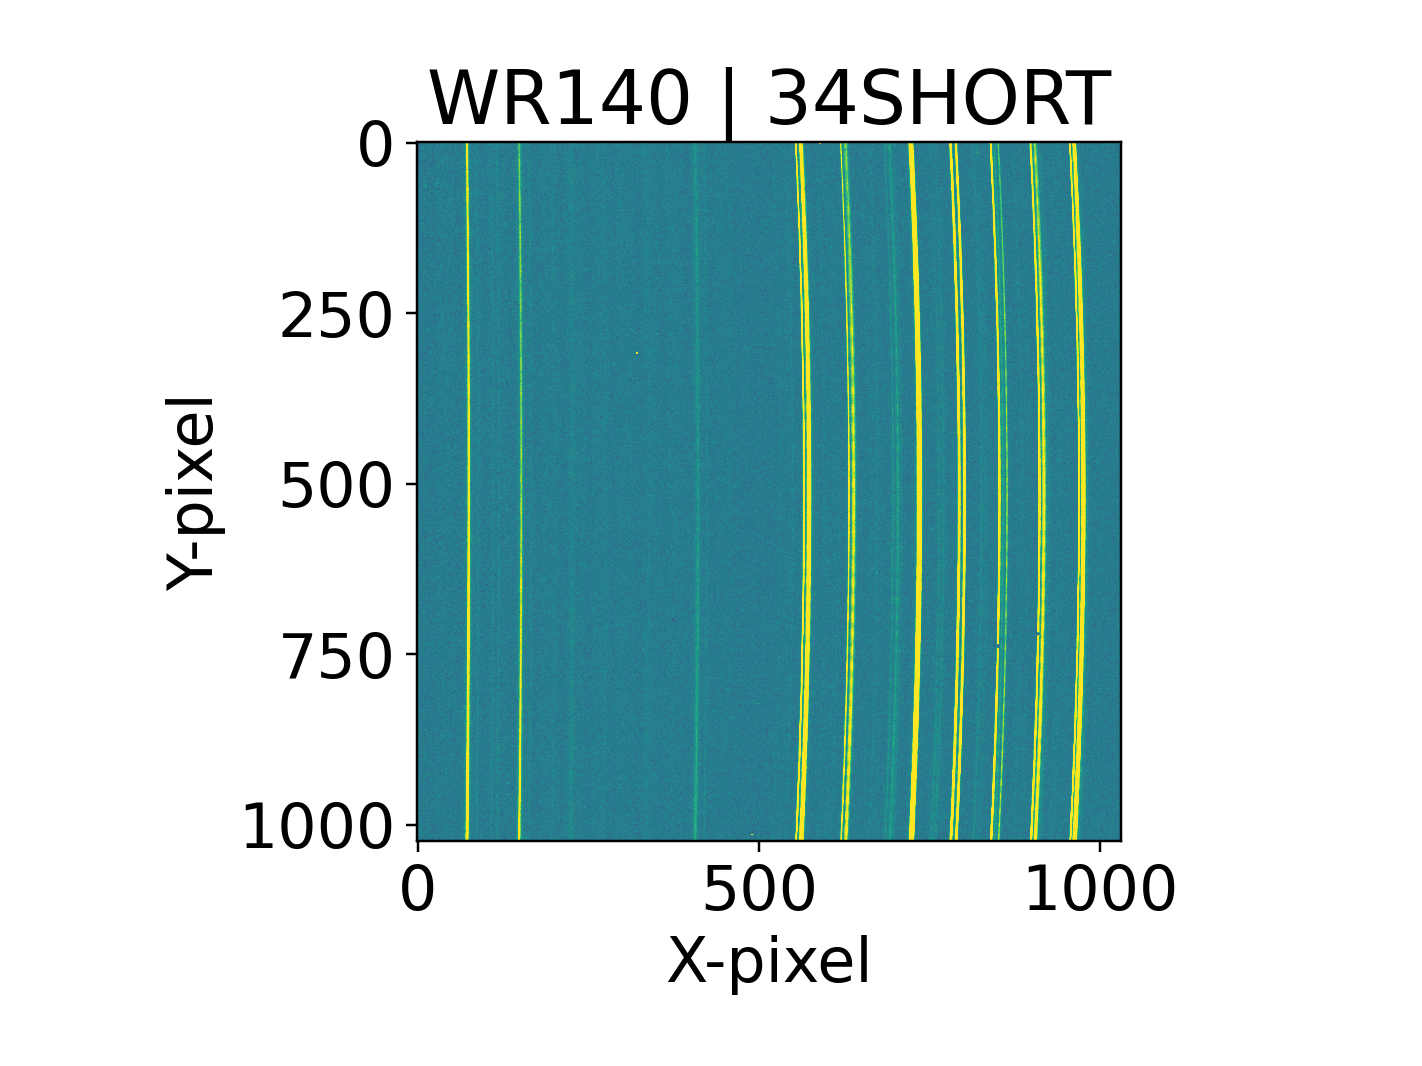

<IPython.core.display.Javascript object>


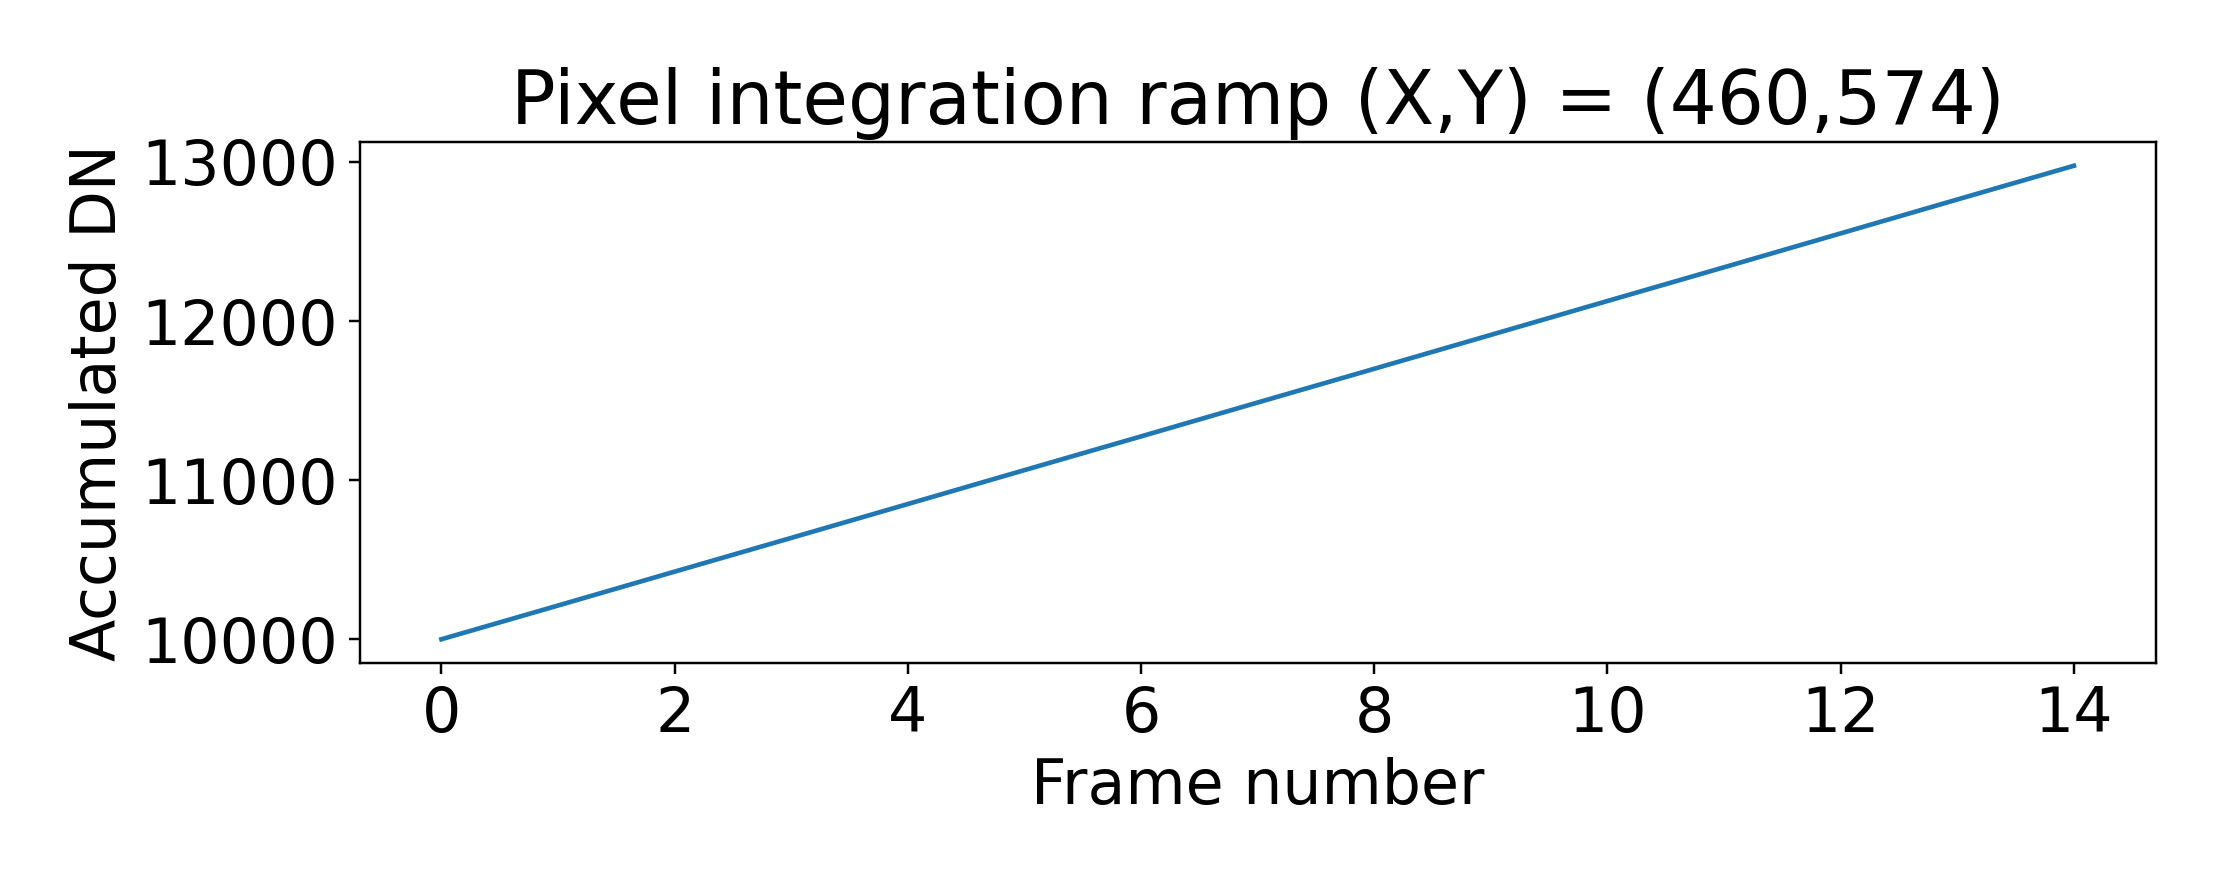

In [20]:
# load rates file
hdu = fits.open(datapath+'det_image_seq1_MIRIFULONG_34SHORTexp1_rate.fits')
wr140_rate_img = hdu['SCI'].data.astype('float')
tframe = hdu[0].header['TFRAME']
hdu.close()

# load pupd models
hdu = fits.open(datapath+'MIRI_FM_MIRIFU_PUPD_0.0.1.fits')
pupd_models_oddrows = hdu['ODDROW'].data.astype(float)
pupd_models_evenrows = hdu['EVENROW'].data.astype(float)
hdu.close()

# load or simulate ramp file
# hdu = fits.open(datapath+'det_image_seq1_MIRIFULONG_34SHORTexp1.fits')
# wr140_ramp_img = hdu['SCI'].data.astype('float')[0,:,:,:]
# hdu.close()
wr140_ramp_img = np.full((15,1024,1032),10000)
for frame in range(15):
    wr140_ramp_img[frame,:,:] = 10000+(wr140_rate_img*tframe)*frame


# produce a few basic plots
plt.figure()
plt.imshow(wr140_rate_img,vmax=10)
plt.title('WR140 | 34SHORT')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.plot(wr140_ramp_img[:,460,574])
plt.title('Pixel integration ramp (X,Y) = (460,574)')
plt.xlabel('Frame number')
plt.ylabel('Accumulated DN')
plt.tight_layout()

### Add pull-up pull-down effect to impacted pixels

### --Identify bright pixels in rates image

<IPython.core.display.Javascript object>


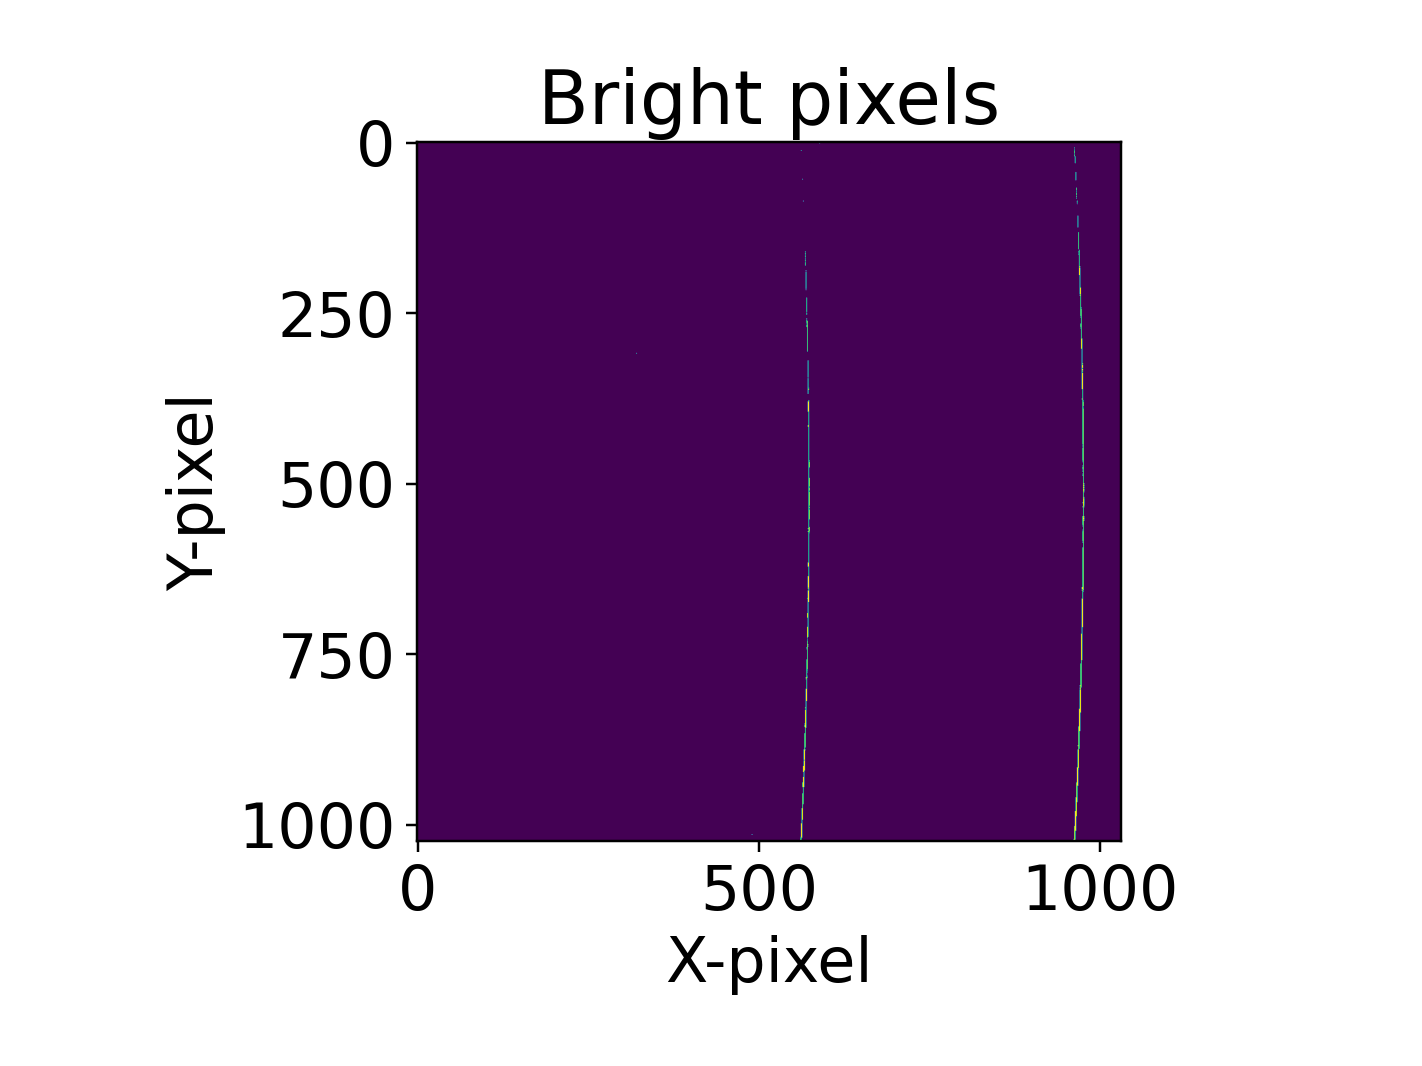

In [21]:
bright_pixel_img = np.zeros((1024,1032))
sel = wr140_rate_img>100 # currently the cut-off value is artificial

bright_pixel_img[sel] = 1

plt.close('all')
plt.figure()
plt.imshow(bright_pixel_img)
plt.title('Bright pixels')
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.tight_layout()

### --Select PUPD model and cut ramp length to length of observation

In [17]:
pupd_model_oddrows = pupd_models_oddrows[0]
pupd_model_evenrows = pupd_models_evenrows[0]

pupd_model_oddrows_cut = pupd_model_oddrows[:15]
pupd_model_evenrows_cut = pupd_model_evenrows[:15]

<IPython.core.display.Javascript object>


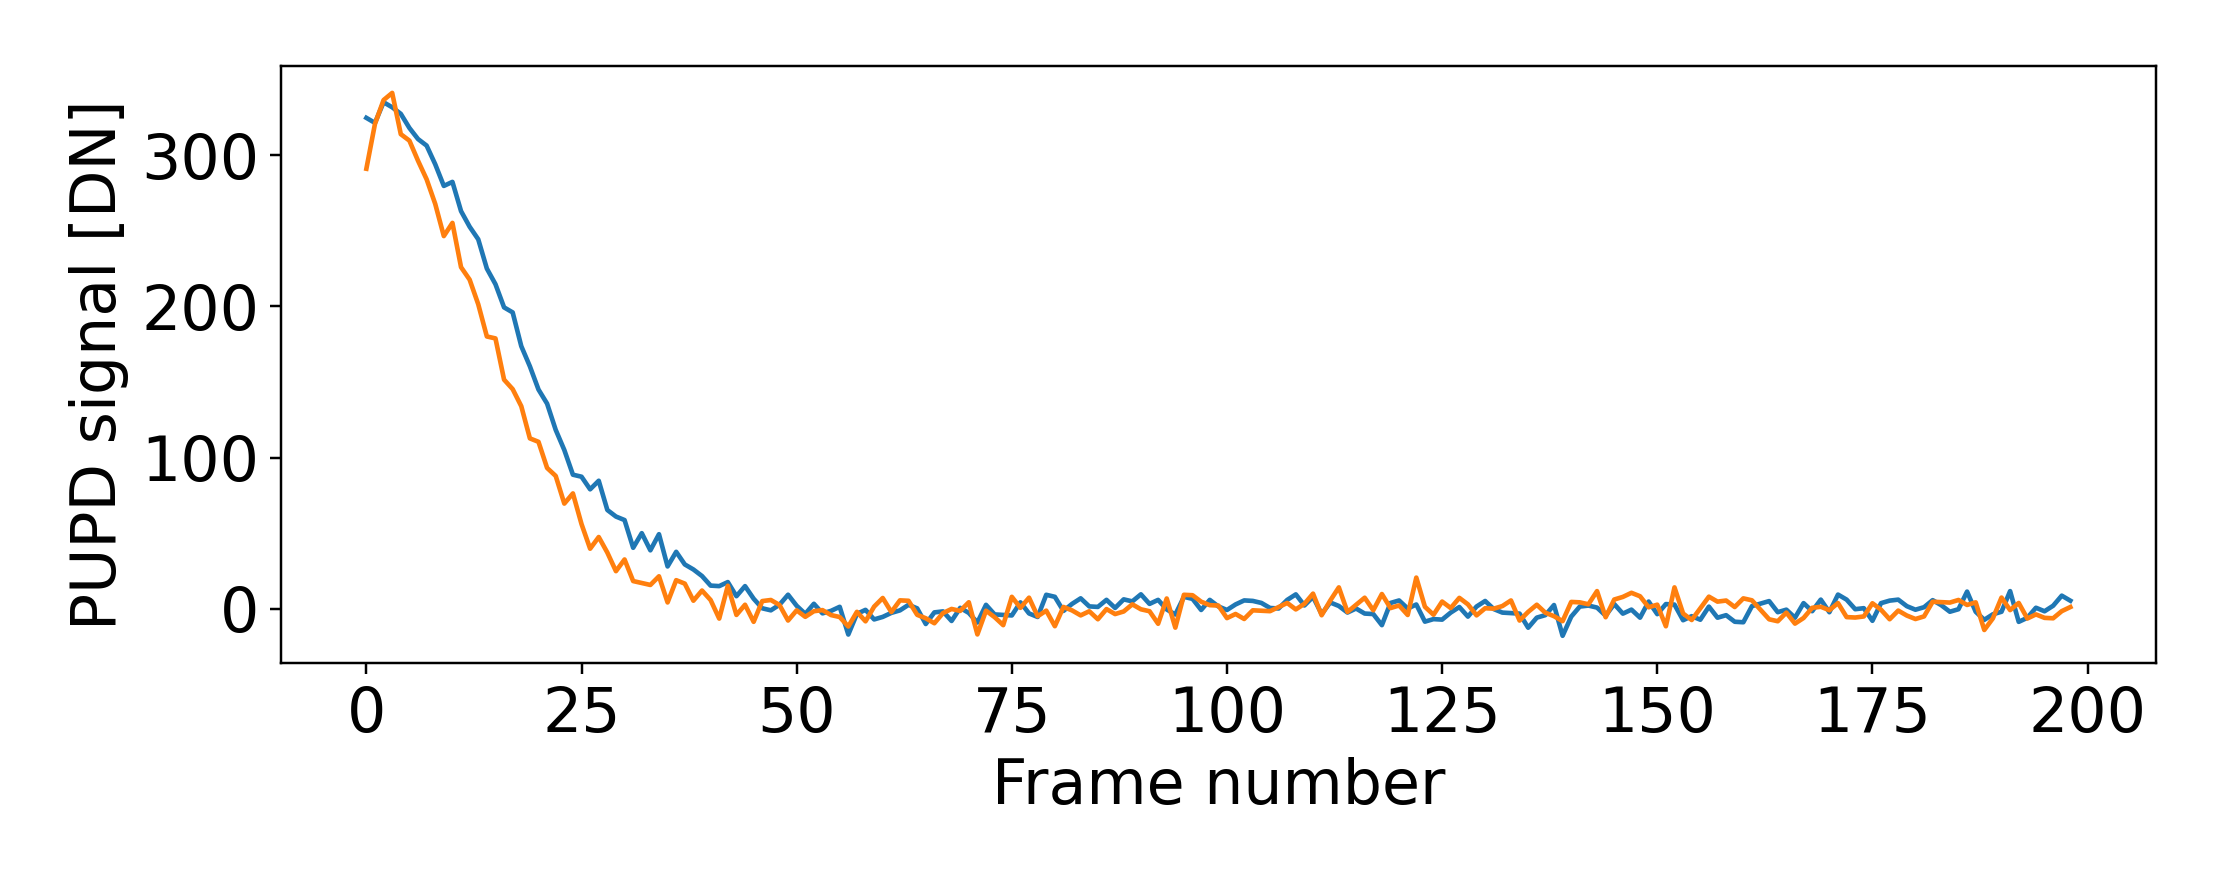

In [18]:
plt.close('all')
plt.figure(figsize=(10,4))
plt.plot(pupd_model_oddrows)
plt.plot(pupd_model_evenrows)
plt.xlabel('Frame number')
plt.ylabel('PUPD signal [DN]')
plt.tight_layout()

### --Add cross-talk effect to impacted pixels

In [22]:
wr140_ramp_img_wPUPD = wr140_ramp_img.copy()
for row in range(1024):
    idxs = np.where(bright_pixel_img[row,:] == 1)[0]
    if len(idxs) ==0:
        continue
    else:
        max_signal = np.max(wr140_rate_img[row,idxs])
        if row%2 == 0:
            for xpos in range(1032):
                wr140_ramp_img_wPUPD[:,row,xpos] = wr140_ramp_img[:,row,xpos]+pupd_model_evenrows_cut
        elif row%2 == 1:
            for xpos in range(1032):
                wr140_ramp_img_wPUPD[:,row,xpos] = wr140_ramp_img[:,row,xpos]+pupd_model_oddrows_cut

### --Plot resulting ramps

<IPython.core.display.Javascript object>


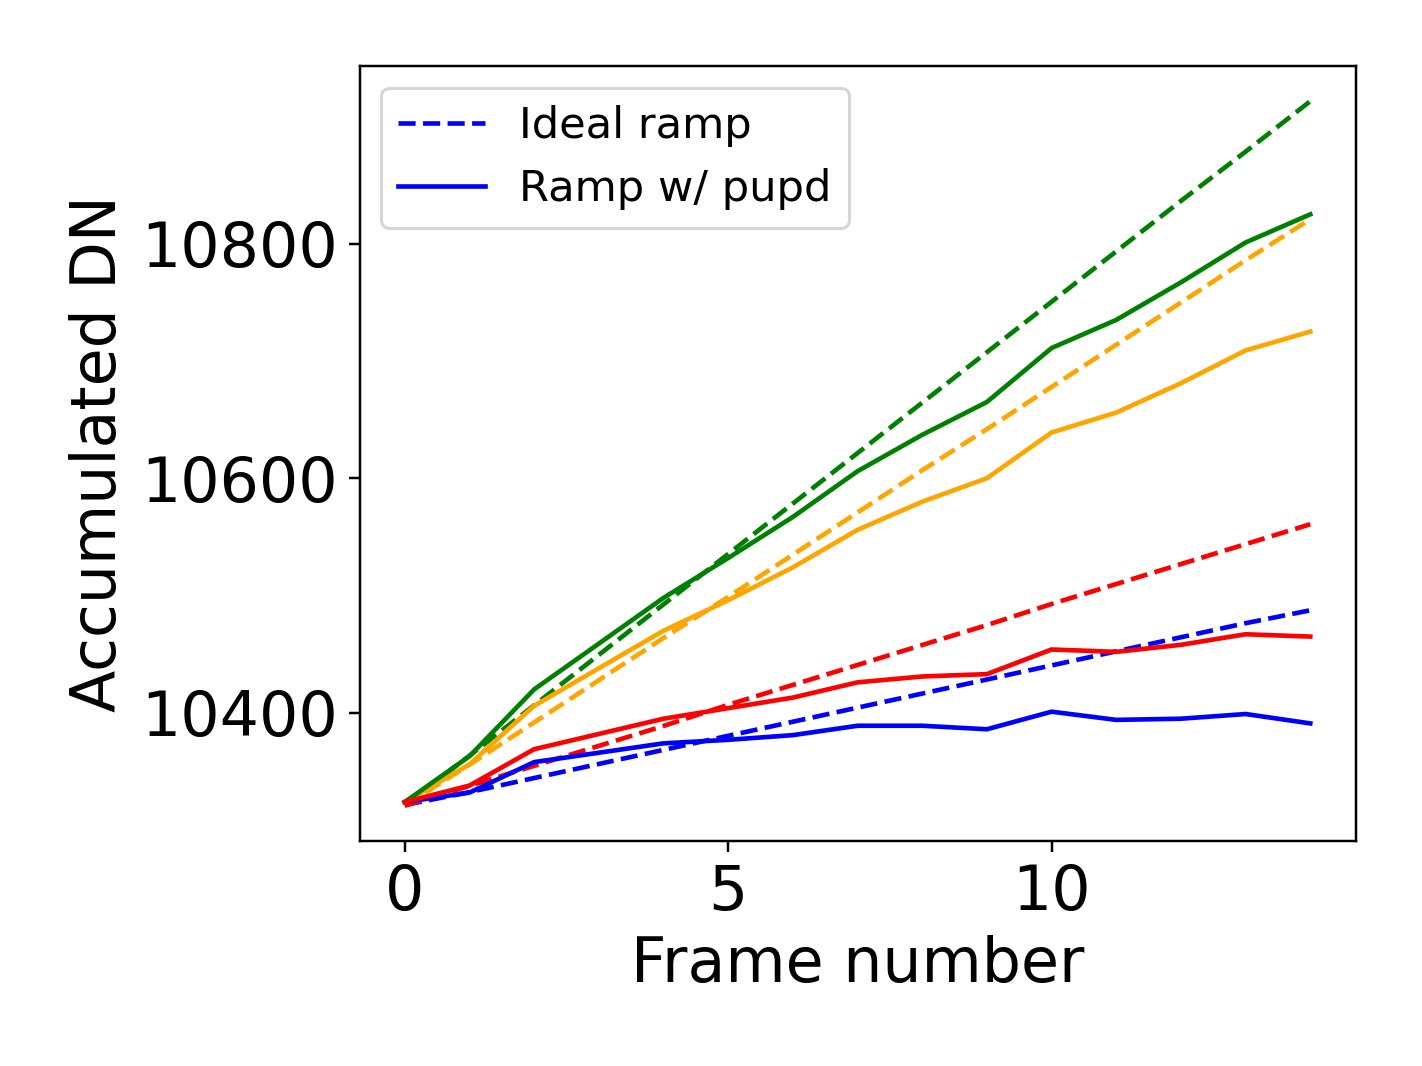

In [9]:
plt.close('all')
plt.figure()

plt.plot(wr140_ramp_img[:,15,71]+pupd_model_oddrows_cut[1],'b',linestyle='dashed',label='Ideal ramp')
plt.plot(wr140_ramp_img[:,15,72]+pupd_model_evenrows_cut[1],'orange',linestyle='dashed')
plt.plot(wr140_ramp_img[:,15,73]+pupd_model_oddrows_cut[1],'g',linestyle='dashed')
plt.plot(wr140_ramp_img[:,15,74]+pupd_model_evenrows_cut[1],'r',linestyle='dashed')

plt.plot(wr140_ramp_img_wPUPD[:,15,71],'b',label='Ramp w/ pupd')
plt.plot(wr140_ramp_img_wPUPD[:,15,72],'orange')
plt.plot(wr140_ramp_img_wPUPD[:,15,73],'g')
plt.plot(wr140_ramp_img_wPUPD[:,15,74],'r')
plt.xlabel('Frame number')
plt.ylabel('Accumulated DN')
plt.legend(loc='upper left',fontsize=14)
plt.tight_layout()

### Empirical correction to the PUPD effect

In [10]:
wr140_ramp_img_wPUPD_corrected = wr140_ramp_img_wPUPD.copy()
for row in range(1024):
    for xpos in range(1032):
        wr140_ramp_img_wPUPD_corrected[:,row,xpos] = (wr140_ramp_img_wPUPD[:,row,xpos]-wr140_ramp_img_wPUPD[:,row,500])+wr140_ramp_img_wPUPD[:,row,xpos][0]

<IPython.core.display.Javascript object>


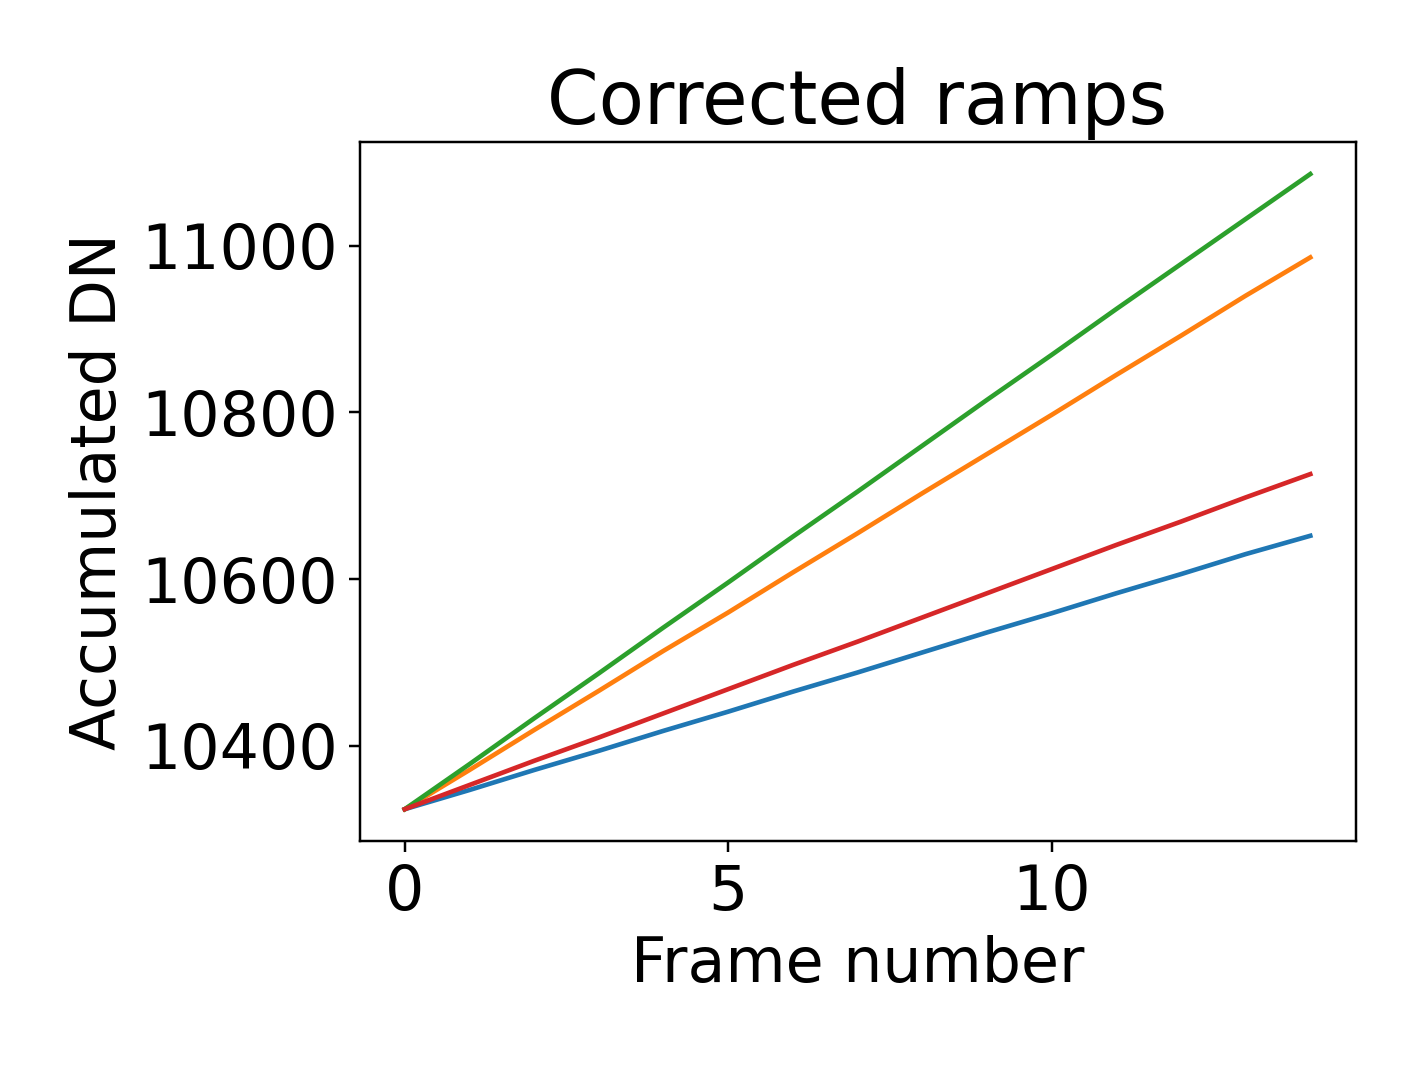

In [11]:
plt.figure()
plt.plot(wr140_ramp_img_wPUPD_corrected[:,15,71])
plt.plot(wr140_ramp_img_wPUPD_corrected[:,15,72])
plt.plot(wr140_ramp_img_wPUPD_corrected[:,15,73])
plt.plot(wr140_ramp_img_wPUPD_corrected[:,15,74])
plt.xlabel('Frame number')
plt.ylabel('Accumulated DN')
plt.title('Corrected ramps')
plt.tight_layout()